In [2]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

torch.Size([1, 1, 512, 512])


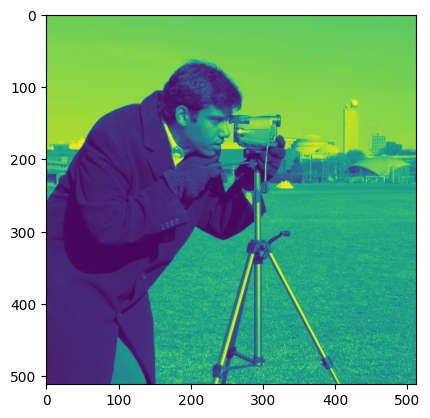

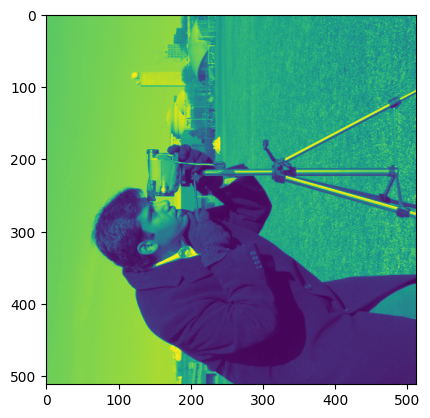

In [3]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import kornia as K
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from skimage import data

camera = K.image_to_tensor(data.camera(), keepdim=False)
camera = camera.float() / 255.
print(camera.shape)
timg = torch.cat([camera,torch.rot90(camera,1,dims=(2,3))], dim=0)
timg_gray = timg


plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

## Processo de detecção e correspondencia com kornia

scale_pyr  ScalePyramid(n_levels=3, init_sigma=1.6, min_size=21, extra_levels=3, border=9, sigma_step=1.2599210498948732, double_image=True)
1 lafs tensor([[  9.9498,   0.0000, 287.4387],
        [  0.0000,   9.9498, 330.4909]])
2 lafs tensor([[  9.9498,   0.0000, 287.4387],
        [  0.0000,   9.9498, 330.4909]])
2 lafs tensor([[ -9.8213,   1.5940, 287.4387],
        [ -1.5940,  -9.8213, 330.4909]])
detector  torch.Size([2, 60, 2, 3]) torch.Size([2, 60])
patches  torch.Size([2, 60, 1, 21, 21])
descs  torch.Size([2, 60, 128])
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([58, 2]) (58, 1)


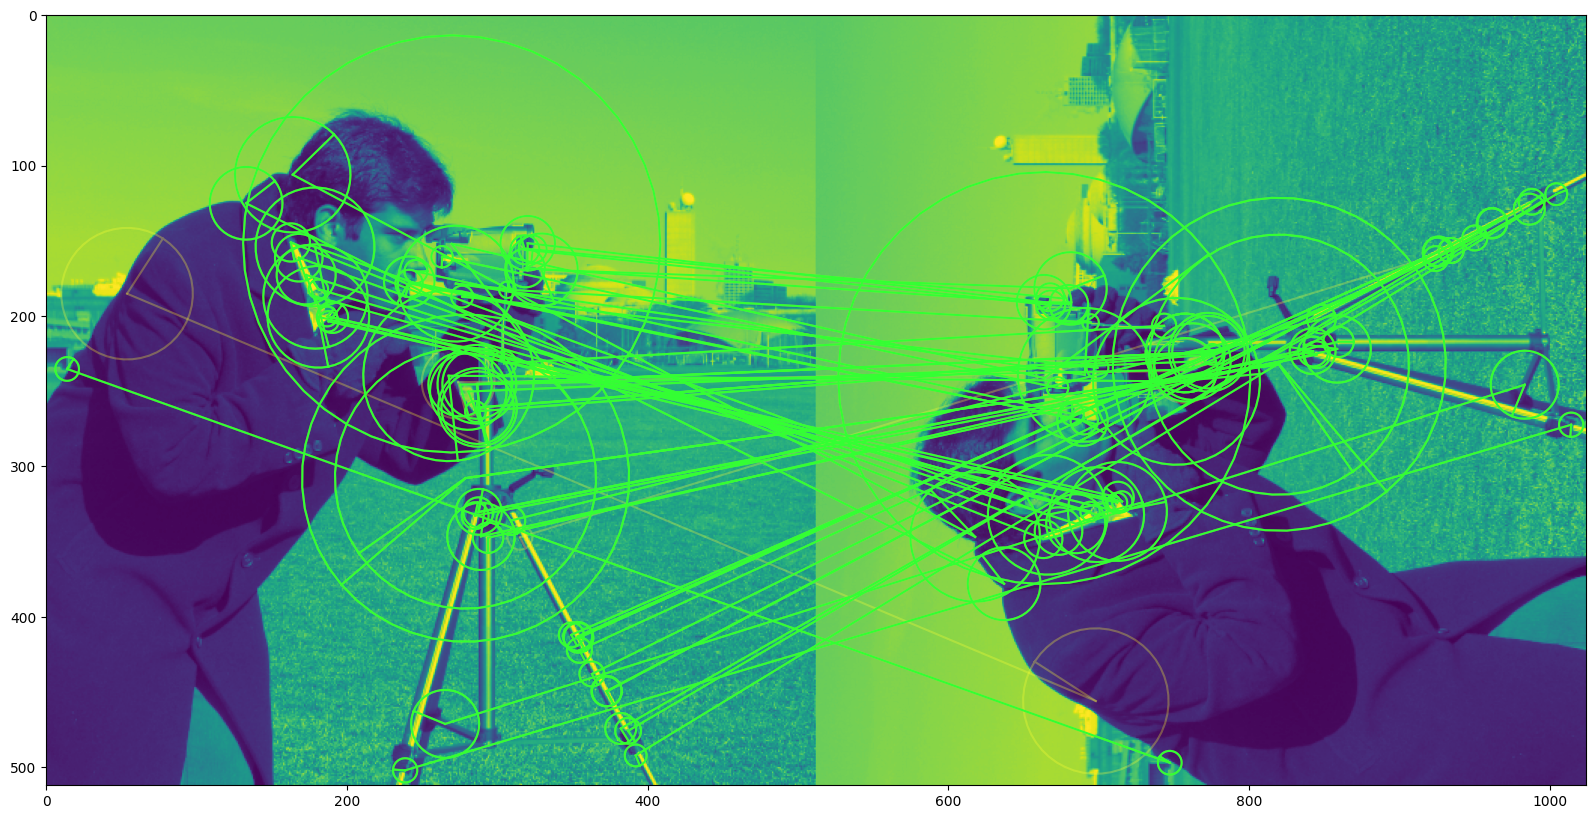

In [4]:
#Now lets define local deature detector and descriptor

device = torch.device('cpu')
#device = torch.device('cuda:0')

PS = 21 # patch size

sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift

resp = BlobHessian()
scale_pyr = kornia.geometry.ScalePyramid(3, 1.6, PS, double_image=True)
print('scale_pyr ',scale_pyr)
nms = kornia.geometry.ConvQuadInterp3d(10)

n_features = 60
detector = ScaleSpaceDetector(n_features,
                              resp_module=resp,
                              nms_module=nms,
                              scale_pyr_module=scale_pyr,
                              ori_module=kornia.feature.LAFOrienter(19),
                              minima_are_also_good=True,
                              mr_size=6.0).to(device)

with torch.no_grad():
    lafs, resps = detector(timg_gray)
    print('detector ',lafs.shape, resps.shape)
    patches =  kornia.feature.extract_patches_from_pyramid(timg_gray, lafs, PS)# o método de extração de patches aceita uma pirâmide de escala e retorna patches de tamanho fixo
    B, N, CH, H, W = patches.size()
    print('patches ',patches.shape)
    # O descritor aceita o tensor padrão [B, CH, H, W], enquanto os patches têm formato [B, N, CH, H, W]
    # Então, precisamos reformular um pouco :)
    descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)# aplica o descritor a cada patch
    print('descs ',descs.shape)
    scores, matches = kornia.feature.match_snn(descs[0], descs[1], 0.9) # correspondencia dos descritories a uma distância de 0.9

# Now RANSAC
src_pts = lafs[0,matches[:,0], :, 2].data.cpu().numpy()
dst_pts = lafs[1,matches[:,1], :, 2].data.cpu().numpy()

F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 100) # 1.0 é a tolerância de reprojeção, 0.999 é a confiança, 100 é o número máximo de iterações

inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]# inliers são os pontos que se encaixam no modelo
# print(inliers_point)
print(lafs[0][None].shape,lafs[0].shape,matches.shape,inliers_mask.shape)

from kornia_moons.viz import *
draw_LAF_matches(
    lafs[0][None],
    lafs[1][None],
    matches,
    K.tensor_to_image(timg_gray[0]),
    K.tensor_to_image(timg_gray[1]),
    inliers_mask,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)

## Aumento de dados caminho de ida e volta e reprodutibilidade

In [1]:
import kornia
img1: torch.Tensor = kornia.image_to_tensor(data.camera(), keepdim=False).float() / 255.
input = torch.cat([img1,img1], dim=0)
B,C,H,W = input.shape
mask = torch.ones(B,C,H,W)
bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)
points = torch.tensor([[[1., 1.]]]).expand(2, -1, -1)
aug_list = kornia.augmentation.AugmentationSequential(
    # kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
    kornia.augmentation.RandomAffine(360, p=1.0),
    # kornia.augmentation.RandomPerspective(0.2, p=1.0),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=False,
    random_apply=10,
)
out = aug_list(input, mask, bbox, points)
# [o.shape for o in out]
# [torch.Size([2, 3, 5, 6]), torch.Size([2, 3, 5, 6]), torch.Size([2, 1, 4, 2]), torch.Size([2, 1, 2])]
# apply the exact augmentation again.
out_rep = aug_list(input, mask, bbox, points, params=aug_list._params)
# [(o == o_rep).all() for o, o_rep in zip(out, out_rep)]
# [tensor(True), tensor(True), tensor(True), tensor(True)]
# inverse the augmentations
out_inv = aug_list.inverse(*out)
# [o.shape for o in out_inv]
# [torch.Size([2, 3, 5, 6]), torch.Size([2, 3, 5, 6]), torch.Size([2, 1, 4, 2]), torch.Size([2, 1, 2])]

plt.imshow(kornia.utils.tensor_to_image(input[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(out[0][0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(out_rep[0][0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(out_inv[0][0]))

NameError: name 'data' is not defined

## Conversao de keypoint para LAF

- como detectar e colocar na estrutura do LAF

In [6]:
# Carregar imagem
image = data.camera()

# Detectar keypoints usando o OpenCV
orb = cv2.ORB_create(nfeatures=15)
keypoints_opencv = orb.detect(image, None)

print(len(keypoints_opencv))


15


In [7]:
for point in keypoints_opencv:
    print(point.pt, point.angle, point.size)

(179.0, 208.0) 288.3113098144531 31.0
(287.0, 333.0) 149.3594970703125 31.0
(294.0, 347.0) 93.01445770263672 31.0
(178.8000030517578, 207.60000610351562) 290.77655029296875 37.20000076293945
(286.8000183105469, 333.6000061035156) 142.4610137939453 37.20000076293945
(294.0, 348.0) 81.32489776611328 37.20000076293945
(178.5600128173828, 207.36001586914062) 292.2406311035156 44.6400032043457
(285.1200256347656, 332.6400146484375) 154.56683349609375 44.6400032043457
(177.98402404785156, 205.63201904296875) 290.93701171875 53.5680046081543
(285.1200256347656, 333.5040283203125) 144.45751953125 53.5680046081543
(178.32962036132812, 207.3600311279297) 289.2074890136719 64.28160858154297
(284.083251953125, 333.8496398925781) 151.09994506835938 64.28160858154297
(179.15908813476562, 204.0422821044922) 288.0754089355469 77.137939453125
(179.15908813476562, 203.04696655273438) 294.72515869140625 92.5655288696289
(179.15908813476562, 200.65818786621094) 303.64251708984375 111.0786361694336


## Exibir imagem e seus pontos no LAF e varias escalas

- incluir detecções com escala de piramides

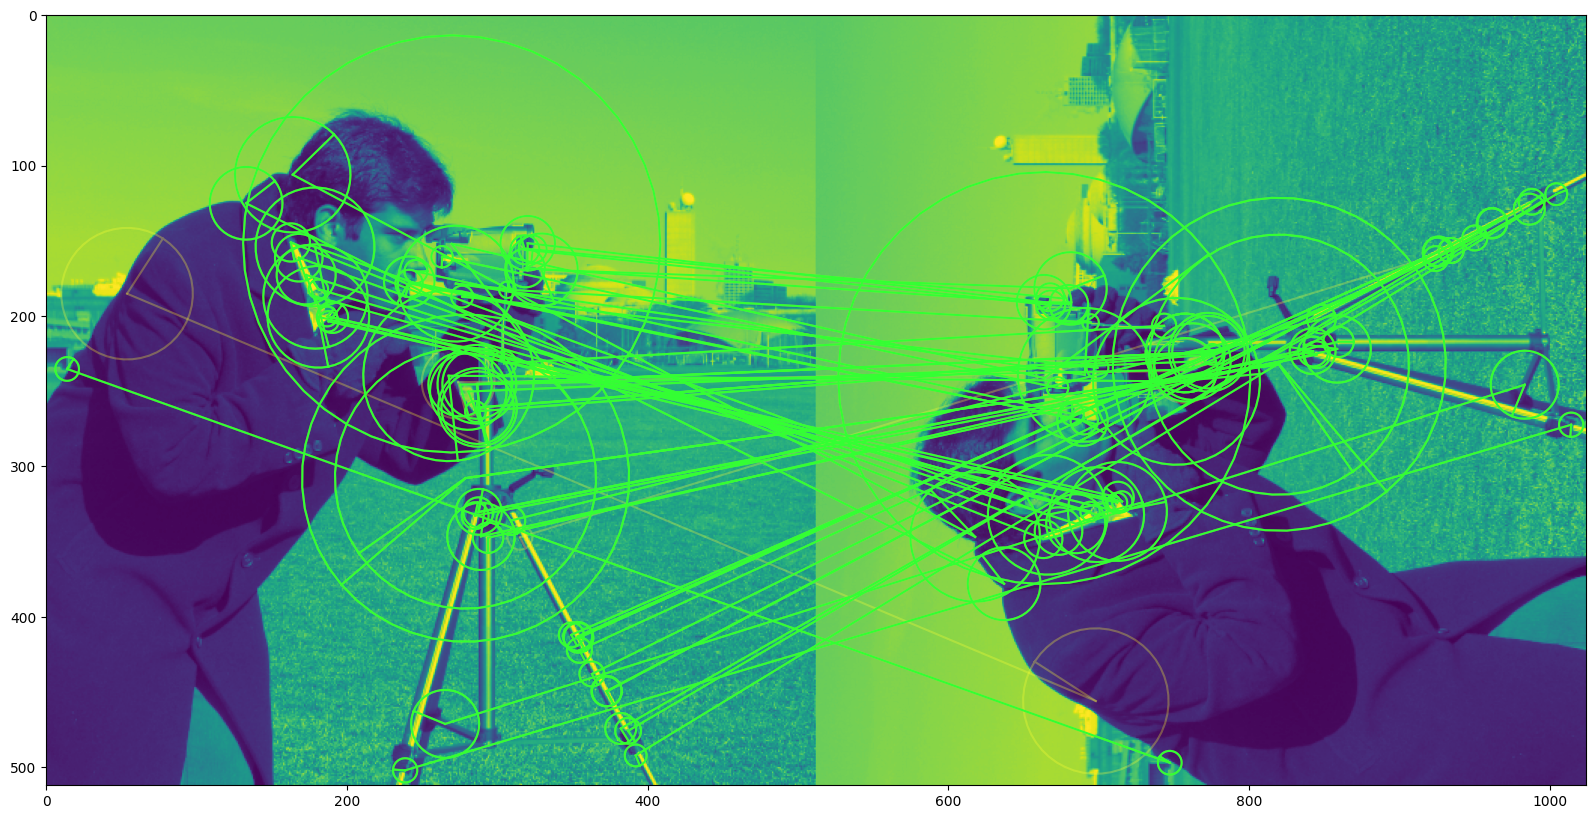

In [8]:

from kornia_moons.viz import *
draw_LAF_matches(
    lafs[0][None],
    lafs[1][None],
    matches,
    K.tensor_to_image(timg_gray[0]),
    K.tensor_to_image(timg_gray[1]),
    inliers_mask,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)

### Dividir a quantidade de pontos por escala

In [9]:
import numpy as np

def divide_points_by_scale(total_points, num_scales):
    reduction_rate = 1.5
    points_per_scale = []
    for i in range(num_scales):
        points_per_scale.append(total_points / (reduction_rate ** i))
    points_per_scale = np.array(points_per_scale)

    fraction = points_per_scale.sum() / total_points

    adjusted_points_per_scale = points_per_scale // fraction
    adjusted_points_per_scale[0] += total_points - adjusted_points_per_scale.sum()

    return adjusted_points_per_scale

# Example usage
total_points = 90
num_scales = 3

adjusted_points_per_scale = divide_points_by_scale(total_points, num_scales)
print(adjusted_points_per_scale)


[44. 28. 18.]


### CustonNetDetector

In [10]:
import torch
import torch.nn as nn

# Definindo o modelo convolucional simples
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv = nn.Conv2d(1, 8, 3)  # Número de canais de entrada: 1, Número de canais de saída: 8, Tamanho do kernel: 3x3
        
    def forward(self, x):
        x = self.conv(x)
        return x

# Criando uma instância do modelo
model = SimpleConvNet()

In [11]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 15, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
}

class CustomNetDetector(MultiResolutionDetector):
    def __init__(
        self,
        model,
        pretrained: bool = False,
        num_features: int = 60,
        keynet_conf=keynet_default_config,
        ori_module=kornia.feature.LAFOrienter(19),
        aff_module=None,#kornia.feature.LAFAffineShapeEstimator(19),
    ):
        super().__init__(model, num_features, keynet_conf['Detector_conf'], ori_module, aff_module)

PS = 31
timg_gray = timg_gray.to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift
detector = CustomNetDetector(model).to(device)


cuda:0
Time for computing upper levels:  0.6894562244415283
Time for computing downsampling levels:  0.08544445037841797
Time for computing upper levels:  0.08350872993469238
Time for computing downsampling levels:  0.07680392265319824
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([38, 2]) (38, 1)


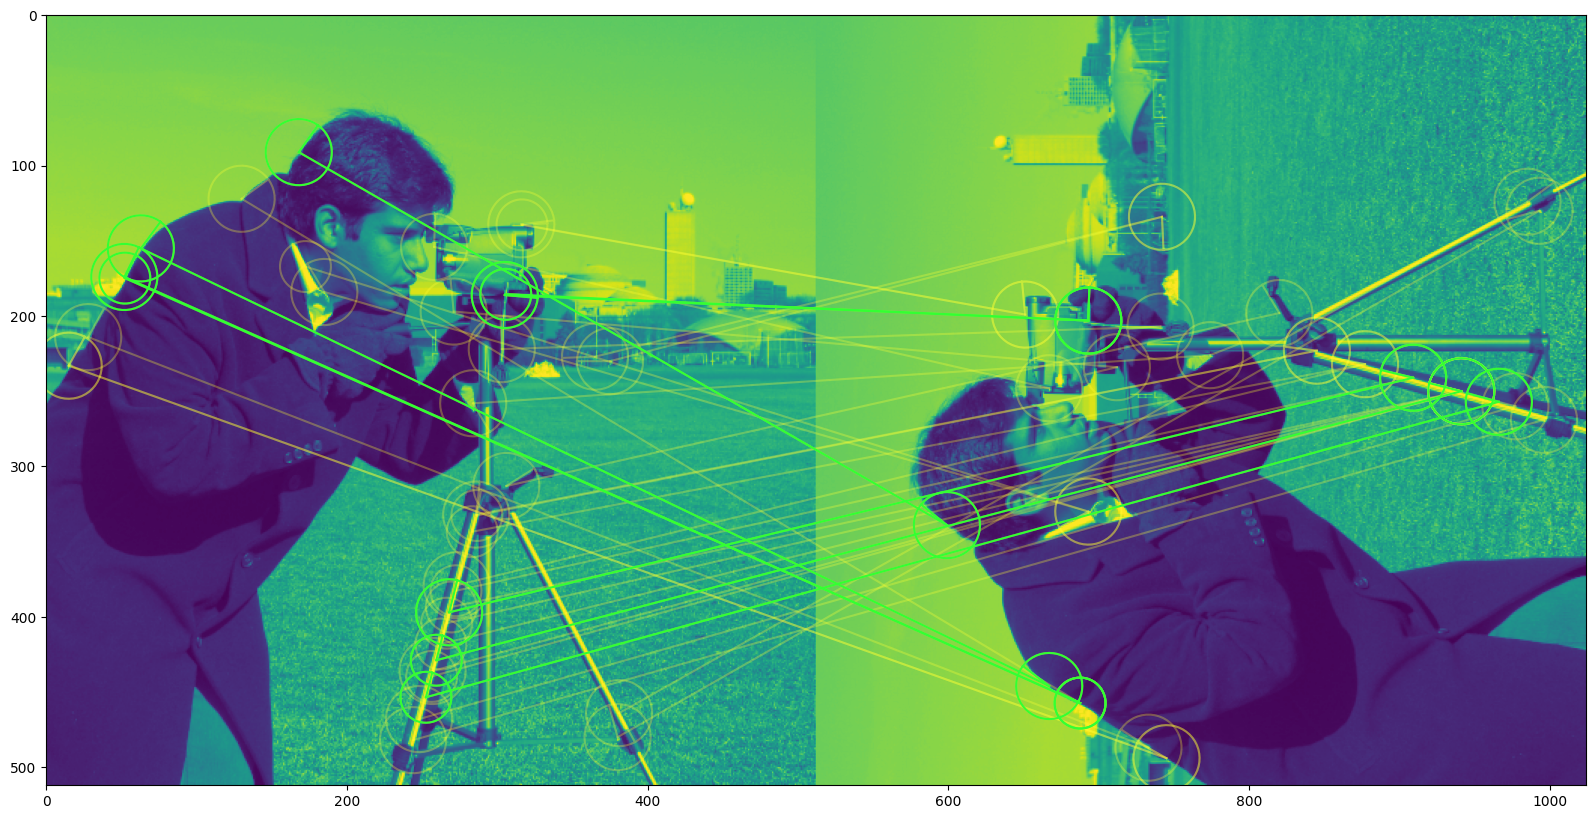

In [12]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 100)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask

print(timg_gray.device)
with torch.no_grad():
    lafs1, descs1 = detect_and_extract_features(timg_gray[0],detector,descriptor,PS)
    
    lafs2, descs2 = detect_and_extract_features(timg_gray[1],detector,descriptor,PS)
    
    scores, matches = kornia.feature.match_snn(descs1[0], descs2[0], 0.9)
    
# Cálculo da homografia
inliers_mask = compute_homography(lafs1, lafs2, matches)
print(lafs1[0][None].shape, lafs1[0].shape, matches.shape, inliers_mask.shape)

from kornia_moons.viz import draw_LAF_matches

draw_LAF_matches(
    lafs1[0][None].cpu(),
    lafs2[0][None].cpu(),
    matches.cpu(),
    kornia.tensor_to_image(timg_gray[0].cpu()),
    kornia.tensor_to_image(timg_gray[1].cpu()),
    inliers_mask,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)